In [1]:
# Import necessary libraries
import pandas as pd
from sqlalchemy import create_engine



In [2]:

# Database connection details
host = "ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech"
port = "5432"
database = "neondb"
user = "neondb_owner"
password = "a9Am7Yy5r9_T7h4OF2GN"

# Create a connection engine
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")

### How many schools are there in each borough?

dbn = unique school identifier, borough only in table 'high_school_directory'
=> basic query with count aggregation - include total_row_count to determine, if there are differences

In [3]:
query_schools_per_borough = """
SELECT borough,
    COUNT(*) as total_rows,
    COUNT(dbn) as school
FROM nyc_schools.high_school_directory
GROUP BY 1
"""

In [12]:
# Execute query and load results directly into pandas
df = pd.read_sql_query(query_schools_per_borough, engine)

# Preview the data
#print(df.head())
df

,borough,total_rows,school
0,Brooklyn,121,121
1,Queens,80,80
2,Staten Island,10,10
3,Manhattan,106,106
4,Bronx,118,118


### Answer: Here's the overview:

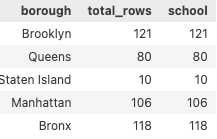

**'%'** within LIKE operations has to be escaped with **'%%'** - '%' itself is a magic commands in Jupyter ;)

Before going to the next questions:
- According to the brief check in dbeaver there are a lot of 'sat'-related tables
- Query all tables in the schema 'nyc_schools', which are not **sat** related

In [5]:
query_dbschema = """
 SELECT * 
 FROM INFORMATION_SCHEMA.TABLES
 WHERE table_schema = 'nyc_schools' AND table_name NOT LIKE '%%sat%%'
 """

df_dbschema = pd.read_sql_query(query_dbschema, engine)
df_dbschema

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,neondb,nyc_schools,school_safety_report,BASE TABLE,None,None,None,None,None,YES,NO,None
1,neondb,nyc_schools,high_school_directory,BASE TABLE,None,None,None,None,None,YES,NO,None
2,neondb,nyc_schools,mytable,BASE TABLE,None,None,None,None,None,YES,NO,None
3,neondb,nyc_schools,school_demographics,BASE TABLE,None,None,None,None,None,YES,NO,None


Now get the columns of the relevant tables

In [6]:
query_table_cols = """
SELECT table_name,
    STRING_AGG(column_name, ', ') AS columns
FROM information_schema.columns
WHERE table_schema = 'nyc_schools' AND table_name IN ('school_safety_report','high_school_directory','school_demographics', 'mytable')
GROUP BY table_name
 """

df_query_table_cols = pd.read_sql_query(query_table_cols, engine)
pd.set_option('display.max_colwidth', None)
df_query_table_cols
# df_dbschema.count()

,table_name,columns
0,high_school_directory,"dbn, school_name, borough, building_code, phone_number, fax_number, grade_span_min, grade_span_max, expgrade_span_min, expgrade_span_max, start_time, end_time, priority01, priority02, priority03, priority04, priority05, priority06, priority07, priority08, priority09, priority10, location, phone_number2, school_email, website, subway, bus, grades2018, finalgrades, total_students, extracurricular_activities, school_sports, attendance_rate, pct_stu_enough_variety, pct_stu_safe, school_accessibility_description, directions1, requirement1, requirement2, requirement3, requirement4, requirement5, program1, code1, interest1, method1, seats9ge1, grade9gefilledflag1, grade9geapplicants1, seats9swd1, grade9swdfilledflag1, grade9swdapplicants1, campus_name, building_borough, building_location, latitude, longitude, community_board, council_district, census_tract, bin, bbl, nta, zip_codes, community_districts, borough_boundaries, city_council_districts, police_precincts, primary_address_line_1, city, state_code, postcode, school_type, overview_paragraph, program_highlights, language_classes, advancedplacement_courses, online_ap_courses, online_language_courses, psal_sports_boys, psal_sports_girls, psal_sports_coed, partner_cbo, partner_hospital, partner_highered, partner_cultural, partner_nonprofit, partner_corporate, partner_financial, partner_other, addtl_info1, addtl_info2, se_services, ell_programs, number_programs, Location 1, Community Board, Council District, Census Tract, Zip Codes, Community Districts, Borough Boundaries, City Council Districts, Police Precincts"
1,mytable,somevalue
2,school_demographics,"dbn, Name, schoolyear, fl_percent, frl_percent, total_enrollment, prek, k, grade1, grade2, grade3, grade4, grade5, grade6, grade7, grade8, grade9, grade10, grade11, grade12, ell_num, ell_percent, sped_num, sped_percent, ctt_num, selfcontained_num, asian_num, asian_per, black_num, black_per, hispanic_num, hispanic_per, white_num, white_per, male_num, male_per, female_num, female_per"
3,school_safety_report,"school_year, building_code, dbn, location_name, location_code, address, borough, geographical_district_code, register, building_name, num_schools, schools_in_building, major_n, oth_n, nocrim_n, prop_n, vio_n, engroupa, rangea, avgofmajor_n, avgofoth_n, avgofnocrim_n, avgofprop_n, avgofvio_n, borough_name, postcode, latitude, longitude, community_board, council_district, census_tract, bin, bbl, nta, _schools"


### Question: What is the average % of English Language Learners (ELL) per borough?

According to the previous result
- ell_percent > school demographics
- borough
    - high_school_directory: borough (initcap long borough)
    - school_safety_report: borough | borough_name (borough = 1 char | borough_name = uppercase long borough)

Strategy:
JOIN both tables with **school_demographics** on 'dbn' check the result. We use LEFT joins to keep the demographics table intact

In [7]:
query_avg_all_join_candidate_table_check = """
SELECT sd.dbn, sd.schoolyear, hs.borough, ss.borough, ss.borough_name
--SELECT COUNT(sd.dbn), COUNT(hs.borough), COUNT(ss.borough), COUNT(ss.borough_name)
FROM nyc_schools.school_demographics sd
LEFT JOIN nyc_schools.high_school_directory hs ON sd.dbn = hs.dbn
LEFT JOIN nyc_schools.school_safety_report ss ON sd.dbn = ss.dbn
--WHERE sd.dbn NOT LIKE '%%M%%' -- capital 'M' seems to be a marker for Manhatten, check, if there are any remainings
"""
df_avg_all_join_candidate_table_check = pd.read_sql_query(query_avg_all_join_candidate_table_check, engine)

pd.set_option('display.max_rows', None)        # Show all rows
display(df_avg_all_join_candidate_table_check)


,dbn,schoolyear,borough,borough,borough_name
0,01M650,20112012,None,M,MANHATTAN
1,01M650,20102011,None,M,MANHATTAN
2,01M650,20092010,None,M,MANHATTAN
3,01M650,20082009,None,M,MANHATTAN
4,01M650,20072008,None,M,MANHATTAN
5,01M650,20062007,None,M,MANHATTAN
6,01M650,20052006,None,M,MANHATTAN
7,01M448,20112012,Manhattan,M,MANHATTAN
8,01M448,20102011,Manhattan,M,MANHATTAN
9,01M448,20092010,Manhattan,M,MANHATTAN


##### Key insight here:

- Borough fill rates out of 725 source rows:
    - high_school_directory: 120
    - school_safety_report: 723

- The table 'high_school_directory' contains 'None' (=NULL) value for boroughs.

- The table school_safety_report almost always provides the borough name in the column **borough_name** in UPPERCASE - we'll keep that in mind for the final query
    - there are 2 rows without a borough name - we will exclude them in the final query
- All dbn records in school_demographics contain 'M' - which indicates Manhatten

Since almost all borough_name records are complete, we avg-aggregate ell_percent on this column

In [8]:
query_avg_ELL = """
SELECT INITCAP(ss.borough_name) as borough,
    ROUND(AVG(sd.ell_percent)::numeric,2) AS avg_ELL -- casting to numeric - otherwise the ROUND function would fail
FROM nyc_schools.school_demographics sd
LEFT JOIN nyc_schools.school_safety_report ss ON sd.dbn = ss.dbn
WHERE ss.borough IS NOT NULL
GROUP BY 1
"""
df_query_avg_ELL = pd.read_sql_query(query_avg_ELL, engine)

pd.set_option('display.max_rows', None)        # Show all rows
display(df_query_avg_ELL)

,borough,avg_ell
0,Manhattan,11.87


### Answer 1: Manhatten - as the only borough, we could determine - has an all time average of **11,87%** of English Language Learners

The result from answer 1 relates to multiple years. Let's get more granular on this

In [9]:
query_avg_by_year_ELL = """
SELECT INITCAP(ss.borough_name) as borough,
    CONCAT(LEFT(sd.schoolyear::varchar,4), '/', RIGHT(sd.schoolyear::varchar,4)) as year,
    -- reformated schoolyear for better understanding
    ROUND(AVG(sd.ell_percent)::numeric,2) AS avg_ELL -- casting to numeric - otherwise the ROUND function would fail
FROM nyc_schools.school_demographics sd
LEFT JOIN nyc_schools.school_safety_report ss ON sd.dbn = ss.dbn
WHERE ss.borough IS NOT NULL
GROUP BY 1, 2
ORDER BY 2 DESC
"""
df_query_avg_by_year_ELL = pd.read_sql_query(query_avg_by_year_ELL, engine)

pd.set_option('display.max_rows', None)
display(df_query_avg_by_year_ELL)

,borough,year,avg_ell
0,Manhattan,2011/2012,12.15
1,Manhattan,2010/2011,12.40
2,Manhattan,2009/2010,12.33
3,Manhattan,2008/2009,11.02
4,Manhattan,2007/2008,11.83
5,Manhattan,2006/2007,11.07
6,Manhattan,2005/2006,12.29


### Answer 2: Manhatten - as the only borough, has the following averages over the years:

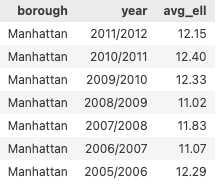

---

### Using the data from the school demographics and high school directory, write a query to find the top 3 schools in each borough with the highest percentage of special education students (sped_percent)

According to the previous result
- ell_percent > school_demographics
- school name related columns
    - school_demographics: Name
    - high_school_directory: school_name
  
Strategy:
JOIN both tables with **school_demographics** on 'dbn' check the result. We use LEFT joins to keep the demographics table intact


In [10]:
query_strategy_check = """
SELECT hs.borough, hs.school_name, sd."Name", sd.dbn, sd.sped_percent -- Name has to be encoded with ' " '
FROM nyc_schools.school_demographics sd
LEFT JOIN nyc_schools.high_school_directory hs ON sd.dbn = hs.dbn
WHERE hs.school_name IS NOT NULL
ORDER BY sd.sped_percent DESC
LIMIT 10
"""
df_strategy_check = pd.read_sql_query(query_strategy_check, engine)

pd.set_option('display.max_rows', None)        # Show all rows
display(df_strategy_check)

,borough,school_name,Name,dbn,sped_percent
0,Manhattan,East Side Community School,EAST SIDE COMMUNITY HIGH SCHOOL,01M450,28.8
1,Manhattan,East Side Community School,EAST SIDE COMMUNITY HIGH SCHOOL,01M450,27.7
2,Manhattan,East Side Community School,EAST SIDE COMMUNITY HIGH SCHOOL,01M450,26.7
3,Manhattan,East Side Community School,EAST SIDE COMMUNITY HIGH SCHOOL,01M450,26.4
4,Manhattan,Marta Valle High School,MARTA VALLE SECONDARY SCHOOL,01M509,25.9
5,Manhattan,East Side Community School,EAST SIDE COMMUNITY HIGH SCHOOL,01M450,25.1
6,Manhattan,Henry Street School for International Studies,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,01M292,25.1
7,Manhattan,Henry Street School for International Studies,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,01M292,24.9
8,Manhattan,East Side Community School,EAST SIDE COMMUNITY HIGH SCHOOL,01M450,24.8
9,Manhattan,East Side Community School,EAST SIDE COMMUNITY HIGH SCHOOL,01M450,24.5


**East Side Community School** has the 3 highest sped_percentages over all times.

Since the question states, we need to find the TOP3 schools
- we need to rank all schools distinctively
- get the highest ranking for each school
- and afterwards get the 3 highest out of them

We'll use an approach with CTE for the ranking part and filtering in the main query

In [11]:
query_highest_sped_schools_per_borough = """
WITH school_ranking AS (
SELECT hs.dbn, hs.borough,
	hs.school_name, sd."Name", sd.dbn, sd.schoolyear, sd.sped_percent,
  ROW_NUMBER() OVER (PARTITION BY hs.borough, hs.school_name ORDER BY sped_percent DESC)
  /* partion by borough AND school_name to get distinct school results - otherwise, we would just replicate previous query's output */
FROM nyc_schools.school_demographics sd
LEFT JOIN nyc_schools.high_school_directory hs ON sd.dbn = hs.dbn
WHERE hs.dbn IS NOT NULL
ORDER BY sd.sped_percent DESC
)

SELECT school_name, sped_percent
FROM school_ranking
WHERE row_number = 1
LIMIT 3
"""
df_highest_sped_schools_per_borough = pd.read_sql_query(query_highest_sped_schools_per_borough, engine)

pd.set_option('display.max_rows', None)        # Show all rows
display(df_highest_sped_schools_per_borough)

,school_name,sped_percent
0,East Side Community School,28.8
1,Marta Valle High School,25.9
2,Henry Street School for International Studies,25.1


### Answer: The top 3 schools in the only borough backed by data are:
- East Side Community School (28.8)
- Marta Valle High School (25.9)
- Henry Street School for International Studies	(25.1)


### 🧠 Insights

- The dbn records seem to have to corresponding borough encoded. I.e. 01**M**450 (M = Manhatten): third char always matches the borough, if available.

- Considering this as indicator for the corresponding borough **would change the whole analysis**, since we would not rely on other tables anymore.